In [1]:
import sys
import time
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

In [3]:
# url_path = '../input/csv-url/data.csv'
# url_image = pd.read_csv(url_path)
# print(url_image.head())

In [4]:
label_path = '../input/labels/label_brand_model_type.csv'
label = pd.read_csv(label_path)
print(label.head())
array_list_label = np.array([label["brand"], label["model"], label["type"]])
labels = []
for j in range(0, len(array_list_label[0])): 
    a = [array_list_label[0][j], array_list_label[1][j], array_list_label[2][j]]
    label = " ".join(a)
    labels.append(label)
print(labels) 

        brand                model      type
0  Cannondale              Trail 6  Mountain
1  Cannondale  Adventure 2 Women's    Hybrid
2  Cannondale              Quick 4      Road
3       Giant              Reign 2  Mountain
4       Giant      Defy Advanced 1      Road
['Cannondale Trail 6 Mountain', "Cannondale Adventure 2 Women's Hybrid", 'Cannondale Quick 4 Road', 'Giant Reign 2 Mountain', 'Giant Defy Advanced 1 Road', 'Giant TCR Advanced 2 Road', 'Giant Simple Single Cruiser', 'Specialized Demo 8 I Mountain', 'Specialized P.3 Mountain', 'Specialized Sirrus Hybrid', 'Specialized Stumpjumper FSR Comp 29er Mountain', 'Trek Fuel EX 7 Mountain', 'Trek 1.2 Road', 'Trek 520 Road', 'Trek 820 Mountain']


In [5]:
data = np.load('../input/data-arr/image_arr.npz')

In [6]:
train_data = data['train_images'].astype('float32')
val_data = data['val_images'].astype('float32')
train_labels = data['train_labels']
val_labels = data['val_labels']

In [7]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [8]:
batch_size = 128

In [9]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)


In [10]:
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam 
vgg19_model = VGG19()

model = Sequential()
for layer in vgg19_model.layers:
    model.add(layer)
    #print(layer.name)
model.layers.pop()
for layer in model.layers:
    layer.trainable = False
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(labels), activation='softmax'))
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
#         loss='sparse_categorical_crossentropy',  
#         metrics=['sparse_categorical_accuracy'])
for layer in model.layers: 
    print(layer.name)

574717952/574710816 [==============================] - 12s 0us/step
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions
batch_normalization
dense
batch_normalization_1
dense_1
batch_normalization_2
dense_2


In [11]:
start = time.time()

model_scratch_info = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 250 # images 10000 = steps * batch_size = 250 * 16
    epochs=40,
    validation_steps=len(val_data)/batch_size, # -> 49 # images 832 = steps * batch_size = 49 * 32
    validation_data=val_generator,
    verbose=1
)
end = time.time()
duration = end - start

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
93/93 [==============================] - 163s 2s/step - loss: 2.7635 - accuracy: 0.1571 - val_loss: 2.7486 - val_accuracy: 0.0656
Epoch 2/40
93/93 [==============================] - 137s 1s/step - loss: 2.2871 - accuracy: 0.2535 - val_loss: 2.8335 - val_accuracy: 0.0656
Epoch 3/40
93/93 [==============================] - 137s 1s/step - loss: 2.1530 - accuracy: 0.2917 - val_loss: 2.9147 - val_accuracy: 0.0656
Epoch 4/40
93/93 [==============================] - 137s 1s/step - loss: 2.0707 - accuracy: 0.3286 - val_loss: 2.8807 - val_accuracy: 0.0656
Epoch 5/40
93/93 [==============================] - 137s 1s/step - loss: 2.0071 - accuracy: 0.3523 - val_loss: 2.7338 - val_accuracy: 0.0775
Epoch 6/40
93/93 [==============================] - 138s 1s/step - loss: 1.9238 - accuracy: 0.3724 - val_loss: 2.5576 - val_accuracy: 0.1023
Epoch 7/40
93/93 [==============================] - 137s 1s/step - loss: 1.8970 - accuracy: 0.3811 - val_loss: 2.2070 - val_accuracy: 0.2659
Epoch 8/40
93

In [12]:
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, 30) )


 model_scratch took 5573.08 seconds (92.9 minutes) to train for 30 epochs


In [13]:
# read image and resize image
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

In [14]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [15]:
def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['accuracy'])), history['accuracy'], 'r')
  plt.plot(np.arange(1, len(history['val_accuracy'])+1), history['val_accuracy'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()


model_scratch


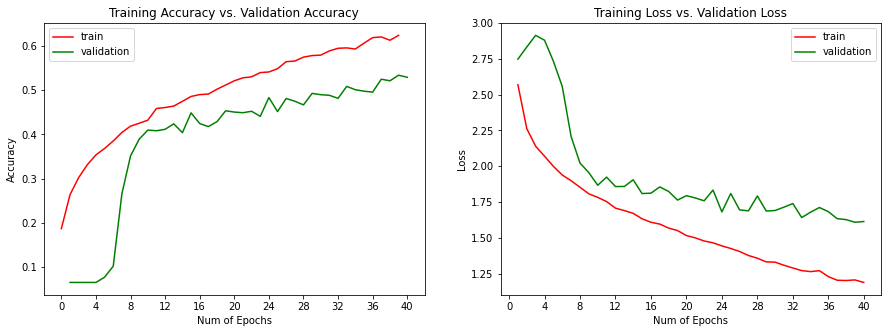

In [16]:
plot_model_history('model_scratch', model_scratch_info.history, 40)

In [17]:
def predict_one_image(img, model):
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)


In [18]:
img_width, img_height = 224, 224
dim = (img_width, img_height)

Cannondale Adventure 2 Women's Hybrid 71%


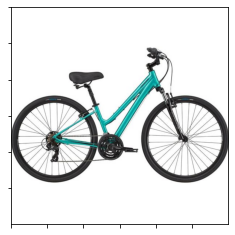

In [19]:
test_img = cv2.imread('../input/test-image/Cannondale_Adventure 2 Women_s_Hybrid.jpg')
pred, probability = predict_one_image(test_img, model)
print('%s %d%%' % (labels[pred], round(probability, 10) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

In [20]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [21]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

Model trained from scatch


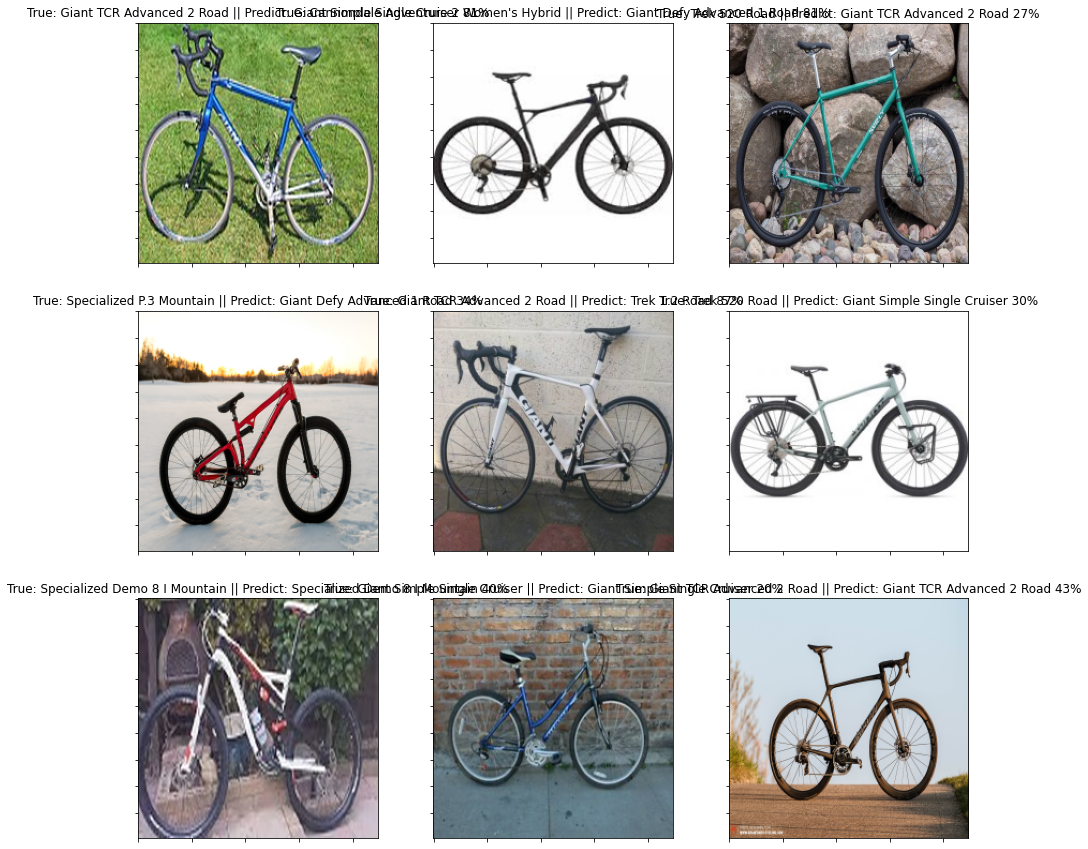

In [22]:
print("Model trained from scatch")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model)
  plt.title('True: %s || Predict: %s %d%%' % (labels[category_idx], labels[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [23]:
# #save model
# from keras.models import model_from_json

# model_json = model.to_json()
# with open("brand_model_type.json", "w") as json_file:
#     json_file.write(model_json)
    
# # save weights to HDF5
model.save("brand_model_type.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
from tensorflow.keras.models import load_model
model = load_model('./brand_model_type.h5')

Cannondale Adventure 2 Women's Hybrid 71%


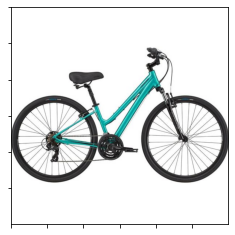

In [25]:
test_img = cv2.imread('../input/test-image/Cannondale_Adventure 2 Women_s_Hybrid.jpg')
pred, probability = predict_one_image(test_img, model)
print('%s %d%%' % (labels[pred], round(probability, 10) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

In [26]:
# model.predict(test_img)